# Training Keras Model

In here is the code for training the keras NN classifier model.

In [133]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from torch.utils.data import DataLoader
from mlsurfzone.lotus_dataset import LotusDataset
from mlsurfzone.validate import validate, plot_cm
from mlsurfzone.transforms import ratings_unhot

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf


import logging
from ipdb import set_trace
import pickle

In [2]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
log = logging.getLogger(__name__)

----

### Get training data

In [3]:
train = LotusDataset(train=True, config_name='config_poor.yaml')

In [4]:
x_train, y_train = train[:]

In [5]:
x_train.shape, y_train.shape

((344387, 26), (344387, 10))

In [6]:
train.full_label_cols

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

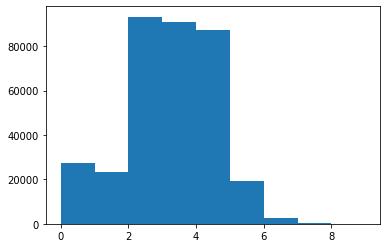

----

### Train model

In [108]:
model = Sequential([
    Dense(512, input_shape=(26,), activation=tf.nn.leaky_relu),
    Dense(256, activation=tf.nn.leaky_relu),
    Dense(128, activation=tf.nn.leaky_relu),
    Dense(64, activation=tf.nn.leaky_relu),
    Dense(64, activation=tf.nn.leaky_relu),
    Dense(32, activation=tf.nn.leaky_relu),
    Dense(10, activation='softmax')
])

In [109]:
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 512)               13824     
_________________________________________________________________
dense_43 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_44 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_45 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_48 (Dense)             (None, 10)               

In [98]:
# Load the validation data now to check overfitting. No "_val.yaml" since we want one-hots here
test = LotusDataset(train=False, config_name='config_poor.yaml')
x_test, y_test = test[:]

In [99]:
np.argmax(y_test, axis=1).max()  # This is wrong. The one-hot encoding doesn't work properly unless you send it the entire dataset at once

8

In [100]:
# Redo the OHE for the test set, so the number of classes matches the train set.
test = LotusDataset(train=False, config_name='config_poor_val.yaml')  # this time with _val so on OHE applied
x_test, y_test = test[:]
n_class = len(train.full_label_cols)
y_test_ohe = np.zeros((len(x_test), n_class))

In [101]:
for i, yval in enumerate(y_test.ravel()):
    y_test_ohe[i][int(yval)-1] = 1

In [102]:
assert np.all((np.argmax(y_test_ohe, axis=1) + 1).astype(int) == y_test.ravel().astype(int))

In [111]:
# Add a LR scheduler before we train
cosine_decay = tf.keras.experimental.CosineDecay(0.001, decay_steps=50)
lr_schedule = lambda epoch: cosine_decay(epoch)

# Train the model, iterating on the data in batches of 200 samples
model.fit(x_train, y_train, epochs=50, batch_size=200, 
          callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)], 
          validation_data=(x_test, y_test_ohe))

Train on 344387 samples, validate on 38250 samples
Epoch 1/50
344387/344387 [==============================] - 4s 12us/sample - loss: 1.1898 - accuracy: 0.4920 - val_loss: 1.0496 - val_accuracy: 0.5414
Epoch 2/50
344387/344387 [==============================] - 4s 11us/sample - loss: 1.0218 - accuracy: 0.5511 - val_loss: 0.9813 - val_accuracy: 0.5660
Epoch 3/50
344387/344387 [==============================] - 4s 10us/sample - loss: 0.9895 - accuracy: 0.5622 - val_loss: 0.9944 - val_accuracy: 0.5613
Epoch 4/50
344387/344387 [==============================] - 4s 10us/sample - loss: 0.9690 - accuracy: 0.5700 - val_loss: 0.9574 - val_accuracy: 0.5770
Epoch 5/50
344387/344387 [==============================] - 4s 11us/sample - loss: 0.9549 - accuracy: 0.5762 - val_loss: 0.9775 - val_accuracy: 0.5696
Epoch 6/50
344387/344387 [==============================] - 4s 11us/sample - loss: 0.9425 - accuracy: 0.5819 - val_loss: 0.9438 - val_accuracy: 0.5819
Epoch 7/50
344387/344387 [=================

---

#### Let's get predictions on the test set.

In [112]:
test = LotusDataset(train=False, config_name='config_poor_val.yaml')
x_test, y_test = test[:]

In [113]:
pred = model.predict(x_test)

In [114]:
df = pd.DataFrame(pred, columns=train.full_label_cols)
df

0             1         2         3         4             5  \
0      1.633952e-08  1.984727e-07  0.001649  0.008762  0.492638  4.136384e-01   
1      9.451012e-06  2.440510e-05  0.004756  0.062490  0.627206  2.896574e-01   
2      9.220845e-11  1.417671e-03  0.988771  0.009709  0.000103  1.204847e-07   
3      4.728911e-09  3.144716e-07  0.000161  0.002739  0.076730  7.548770e-01   
4      9.780065e-05  3.051346e-05  0.001095  0.008765  0.255368  6.104395e-01   
...             ...           ...       ...       ...       ...           ...   
38245  5.331530e-06  3.698438e-05  0.000654  0.007621  0.748805  2.247535e-01   
38246  1.014247e-05  4.210825e-05  0.001816  0.026970  0.670323  2.645819e-01   
38247  1.539957e-06  8.163106e-05  0.002911  0.058713  0.870811  6.614064e-02   
38248  4.829884e-06  2.929737e-05  0.001445  0.021254  0.679480  2.618706e-01   
38249  2.525694e-04  1.546386e-04  0.002580  0.037574  0.673259  2.591905e-01   

                  6             7             8             9  
0      8.331183e-02  2.695593e-07  6.351999e-33  1.616322e-37  
1      1.585233e-02  4.626289e-06  8.319411e-29  3.756001e-33  
2      8.720156e-10  4.116306e-14  0.000000e+00  0.000000e+00  
3      1.654894e-01  3.039361e-06  4.161205e-29  1.023787e-32  
4      1.233768e-01  8.268112e-04  4.725056e-15  2.166160e-17  
...             ...           ...           ...           ...  
38245  1.812124e-02  3.309340e-06  4.901238e-23  6.021584e-26  
38246  3.624881e-02  7.907009e-06  4.517137e-24  7.524214e-28  
38247  1.341180e-03  2.352732e-08  4.003548e-32  3.068684e-36  
38248  3.591158e-02  4.256110e-06  1.019052e-24  1.475318e-28  
38249  2.678314e-02  2.062042e-04  2.316506e-18  7.003382e-21  

[38250 rows x 10 columns]

Getting prediction bins out of softmax: 

In [115]:
am_pred = np.argmax(pred, axis=1)
y_pred = am_pred

In [116]:
pred_df = pd.DataFrame(am_pred)
pred_df[0].value_counts().sort_values()

9        1
8        1
7       12
6      160
5     1776
1     2066
0     3160
3     9906
2    10131
4    11037
Name: 0, dtype: int64

Pickling predictions for use in validation!

In [117]:
with open('keras_clf_pred.pkl', 'wb') as f: 
    pickle.dump(y_pred, f)

----

This model shows an absurd lack of 'VERY_POOR' labels

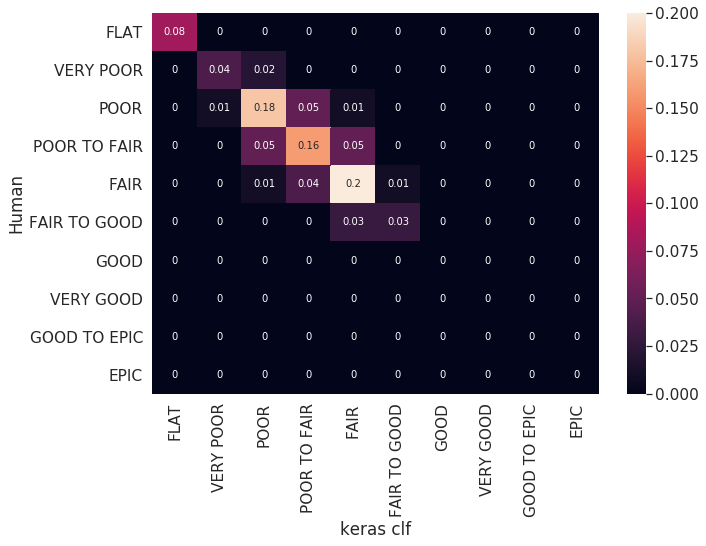

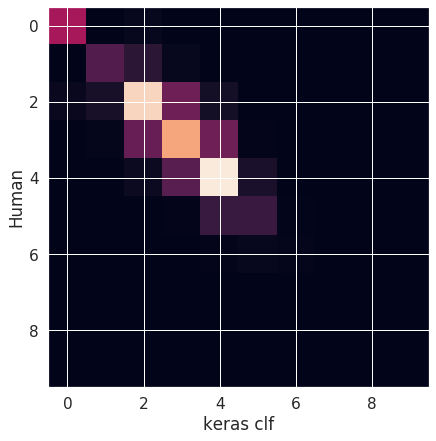

In [118]:
plot_cm(y_pred+1, y_test, name='keras clf', normalize_over='all',
        bin_labels=['FLAT', 'VERY POOR', 'POOR', 'POOR TO FAIR', 
                    'FAIR', 'FAIR TO GOOD','GOOD',
                    'VERY GOOD', 'GOOD TO EPIC', 'EPIC'])

## Check out training distributions 

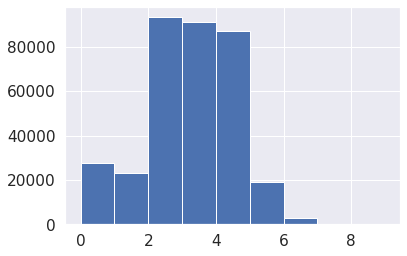

In [29]:
_=plt.hist(np.argmax(y_train, axis=1), bins=9)

In [30]:
np.count_nonzero(np.argmax(y_train, axis=1)==1)

23235

In [48]:
# lol training set has 2 samples from "VERY_POOR" class. What does test distro look like?

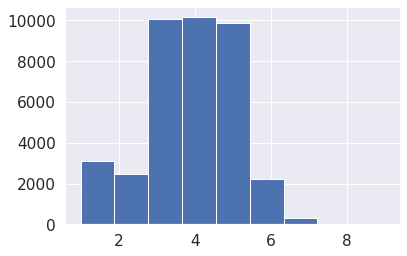

In [31]:
_=plt.hist(y_test.ravel(), bins=9)

In [32]:
np.count_nonzero(y_test.ravel()==1)

3118